# 12-752 Course Project

#### Xiaowen Gu (xiaoweng), Kenan Zhang (kenanz)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

### 1. Load Data

#### 1.1 Energy Data of Gates

In [3]:
gatesDateConverter = lambda d : dt.datetime.strptime(d,'%m/%d/%Y %H:%M')
gates_elect = np.genfromtxt('pointData_gates.csv',delimiter=",",names=True,
            dtype=[dt.datetime,'f8'],converters={0: gatesDateConverter})

In [4]:
print gates_elect['Time'][0],gates_elect['Time'][-1]
print gates_elect['Time'][1]-gates_elect['Time'][0]
print np.max(np.diff(gates_elect['Time'])),np.min(np.diff(gates_elect['Time']))

2014-12-10 00:02:00 2015-11-10 23:55:00
0:15:00
1 day, 6:47:00 -1 day, 23:15:00


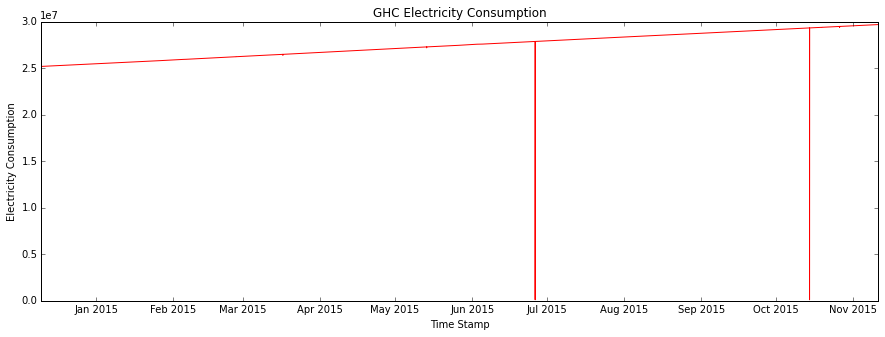

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(gates_elect['Time'],gates_elect['Value'],'r')
plt.xlabel('Time Stamp')
plt.ylabel('Electricity Consumption')
plt.title('GHC Electricity Consumption')

As is shown in the figure, the load data is cumulated energy consumption from Dec 2014 to Dec 2015 with some time missing. The regular time interval is 15min.

#### 1.2 Occupancy Data of Gates

In [ ]:
occDateConverter = lambda d : dt.datetime.strptime(d,'%d-%b-%Y %H:%M:%S')
occ_all = np.genfromtxt('occ_clean.csv',delimiter=",",
                        dtype=[('timestamp', type(dt.datetime.now)),('id','f8'),('occ', 'f8')],
                        converters={0: occDateConverter}, skip_header=1)

In [ ]:
print "First sample is Office %d with occupancy %d on %s"%(occ_all['id'][0],occ_all['occ'][0],occ_all['timestamp'][0])
print occ_all['timestamp'][1]-occ_all['timestamp'][0]

In [ ]:
sample_office=occ_all[np.where(occ_all['id']==1)]

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(sample_office['timestamp'],sample_office['occ'],'r')
plt.xlabel('Time Stamp')
plt.ylabel('Occupancy')
plt.title('Occupancy of Office 1')
plt.ylim(0,1.5)

As is shown in the figure, generally the occupancy data is from Sep 2014 to Dec 2015 with some time missing. And the time interval is around 20min but not regular.

#### 1.3 Energy Data of Other Building

In [ ]:
bakerDateConverter = lambda d : dt.datetime.strptime(d,'%m/%d/%Y %H:%M')
baker_elect = np.genfromtxt('baker_energy.csv',delimiter=",",names=True,
            dtype=[dt.datetime,'f8'],converters={0: bakerDateConverter})

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(baker_elect['Time'],gates_elect['BakerHall'],'r')
plt.xlabel('Time Stamp')
plt.ylabel('Electricity Consumption')
plt.title('Baker Hall Electricity Consumption')

#### 1.4 Temperature Data

In [ ]:
temperatureDateConverter = lambda d : dt.datetime.strptime(d,'%Y-%m-%d %H:%M:%S')
temperature = np.genfromtxt('temperature.csv',delimiter=",",
                            dtype=[('timestamp', type(dt.datetime.now)),('tempF', 'f8')],
                            converters={0: temperatureDateConverter}, skip_header=1)

In [ ]:
plt.plot(temperature['timestamp'])

In [ ]:
print "The minimum difference between any two consecutive timestamps is: " + str(np.min(np.diff(temperature['timestamp'])))
print "The maximum difference between any two consecutive timestamps is: " + str(np.max(np.diff(temperature['timestamp'])))   

As there is no gap, change time interval to 15 minutes.

In [ ]:
new_temperature = temperature[0:-1:3]

In [ ]:
print "First timestamp is on \t{}. \nLast timestamp is on \t{}.".format(temperature['timestamp'][0], temperature['timestamp'][-1])

### 2. Clean Data

#### 2.1 Energy Data

Calculate the electricity consumption for each interval

In [ ]:
gates_elect_value = []
for i in range (1, len(gates_elect['Value'])):
    gates_elect_value.append(gates_elect['Value'][i]-gates_elect['Value'][i-1]) 

In [ ]:
print(len(gates_elect_value))
print(len(gates_elect['Value']))

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(gates_elect['Time'][1:],gates_elect_value)
plt.xlabel('Time')
plt.ylabel('Electricity [kWh]')
plt.ylim(-500,3000)

In [ ]:
gates_elect_value = np.array(gates_elect_value)
value = np.where((gates_elect_value>10)*(gates_elect_value<200))

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(gates_elect['Time'][1:][value],gates_elect_value[value],'-b')
plt.xlabel('Time')
plt.ylabel('Electricity [kWh]')
plt.ylim(80,200)

In [ ]:
print "Power data from {0} to {1}.\nTemperature data from {2} to {3}".format(gates_elect['Time'][1:][value][0], gates_elect['Time'][1:][value][-1],new_temperature['timestamp'][2:][0], new_temperature['timestamp'][2:][-1])

In [ ]:
new_temperature = new_temperature[0:-24] 

In [ ]:
newElectValues = interp(gates_elect['Time'][1:][value], gates_elect_value[value], new_temperature['timestamp'][2:])

In [ ]:
toposix = lambda d: (d - dt.datetime(1970,1,1,0,0,0)).total_seconds()

timestamp_in_seconds = map(toposix,new_temperature['timestamp'])
timestamps = new_temperature['timestamp'][2:]
temp_values = new_temperature['tempF'][2:]
elect_values = newElectValues
print(timestamps[0],timestamps[-1])

In [ ]:
len(temp_values)==len(elect_values)

In [ ]:
weekday = map(lambda t: t.weekday(), timestamps)
weekday = np.array(weekday)
weekends = np.where(weekday>=5) ## Note that depending on how you do this, the result could be a tuple of ndarrays.
weekdays = np.where(weekday<5)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(timestamps[weekdays[0]],elect_values[weekdays[0]],'--b')
plt.figure(figsize=(15,5))
plt.plot(timestamps[weekdays[0]], temp_values[weekdays[0]], '--r')

#### 2.2 Occupancy Data

##### Find the latest starting time and the earliest ending time

In [ ]:
def startEndOffice(id_office,occ):
    n=len(id_office)
    startEndList=np.empty([n,2],dtype=type(dt.datetime.now))
    for i in range(n):
        office=occ[np.where(occ['id']==id_office[i])]
        startEndList[i,:]=np.array([office['timestamp'][0],office['timestamp'][-1]])  
    return startEndList

Test startEndOffice function

In [ ]:
sample_start_end_office=startEndOffice([1],sample_office)
print min(sample_start_end_office[:,0])
print max(sample_start_end_office[:,1])

Find and print the latest starting time and the earliest ending time of all offices

In [ ]:
id_office=np.unique(occ_all['id'])

In [ ]:
start_end_office=startEndOffice(id_office,occ_all)
print max(start_end_office[:,0]),min(start_end_office[:,1])

In [ ]:
date_1=dt.datetime(2014,10,28)
date_2=dt.datetime(2015,12,10)
print date_1.weekday(),date_2.weekday()

The latest starting date is 2014-10-28 Tue; the earliest ending date is 2015-12-10 Thu

##### Initiate the Time Series of Building Occupancy

In [ ]:
def generateTimeSeries(start,end,step):
    #generat a time series with input start, end and step
    #skip weekends
    ts = []
    t=start
    while t <= end:
        if t.weekday() < 5:
            ts.append(t)
        t += step
    return ts

Test generateTimeSeries function

In [ ]:
start=dt.datetime(2015,12,3)
end=dt.datetime(2015,12,5,23,45)
step = dt.timedelta(minutes=15)
print start,end,step
ts_test=generateTimeSeries(start,end,step)
print ts_test[0],ts_test[-1]

Generate an occupancy time series with starting time 2014-11-03 00:00:00 Mon, ending time 2015-12-04 23:45:00 Fri and time step 15min without weekends.

In [ ]:
start=dt.datetime(2014,11,3,0,0)
end=dt.datetime(2015,12,4,23,45)
step = dt.timedelta(minutes=15)
ts_occ=generateTimeSeries(start,end,step)
print ts_occ[0],ts_occ[-1]
print np.shape(ts_occ)

### 3. Prepare Data

#### 3.1 Harmonize Time Series

In [ ]:
def interp(tP, P, tT):
    # This function assumes that the input is an numpy.ndarray of datetime objects

    # Most useful interpolation tools don't work well with datetime objects
    # so we convert all datetime objects into the number of seconds elapsed
    # since 1/1/1970 at midnight (also called the UNIX Epoch, or POSIX time):
    
    toposix = lambda d: (d - dt.datetime(1970,1,1,0,0,0)).total_seconds()
    tP = map(toposix, tP)
    tT = map(toposix, tT)
    
    # Now we interpolate
    from scipy.interpolate import interp1d
    f = interp1d(tP, P,'linear')
    
    return f(tT)

#### 3.2 Calculate Occupancy Level

Test occupancy interpolation

In [ ]:
sample_interp=interp(sample_office['timestamp'],sample_office['occ'],ts_occ)
print np.shape(sample_interp)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(ts_occ,sample_interp,'r')
plt.xlabel('Time Stamp')
plt.ylabel('Occupancy')
plt.title('Interpolated Occupancy of Office 1')
plt.ylim(0,1.5)

In [ ]:
def interpOcc(id_office,occ_all,ts_occ):
    occ=np.zeros(len(ts_occ))
    for i in range(len(id_office)):
        office=occ_all[np.where(occ_all['id']==id_office[i])]
        occ=np.add(occ,interp(office['timestamp'],office['occ'],ts_occ))
    occ_interp=np.ndarray(shape=(len(ts_occ)),dtype=[('timestamp',dt.datetime),('occ',float)])
    occ_interp['timestamp']=ts_occ
    occ_interp['occ']=np.divide(occ,len(id_office))
    return occ_interp    

Test interpOcc function

In [ ]:
sample_office_2=occ_all[(occ_all['id']==1)|(occ_all['id']==2)]
print np.shape(sample_office_2)

In [ ]:
sample_interp_2=interpOcc([1,2],sample_office_2,ts_occ)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(ts_occ,sample_interp_2['occ'],'r')
plt.xlabel('Time Stamp')
plt.ylabel('Occupancy')
plt.title('Interpolated Occupancy of Office 1 & 2')
plt.ylim(0,1.5)

Interpolate occupancy data and calculate occupancy level

In [ ]:
occ_interp=interpOcc(id_office,occ_all,ts_occ)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(ts_occ,occ_interp['occ'],'b')
plt.xlabel('Time Stamp')
plt.ylabel('Occupancy')
plt.title('Interpolated GHC Occupancy Level')
plt.ylim(0,1)

As is shown in the figure, there is missing data in Aug and Sep. Besides, the occupancy level was relatively low during the Jan and late Jun due to the winter and summer break. Therefore, we further zoom into spring and fall semester to determine the time period used in our study.

#### 3.3 Crop Study Period

According the academic calendar of CMU, Fall 2014 ended by Dec 12 while Spring 2015 started from Jan 12. Therefore, we firstly plot the occupancy from Nov 3 to Dec 12.

In [ ]:
t_1=dt.datetime(2014,12,13)
occ_1=occ_interp[np.where(occ_interp['timestamp']<t_1)]
print np.shape(occ_1)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(occ_1['timestamp'],occ_1['occ'],'b')
plt.xlabel('Time Stamp')
plt.ylabel('Occupancy')
plt.title('GHC Occupancy Level Fall 2014 (Nov 3 to Dec 12)')
plt.ylim(0,1)

Similarly, we plot spring and summer semester of 2015, specifically from Jan 12 to May 15 and from May 18 to Aug 7. Fall 2015 started from Aug 31.

In [ ]:
t_2=dt.datetime(2015,1,12)
t_3=dt.datetime(2015,5,16)
t_4=dt.datetime(2015,5,18)
t_5=dt.datetime(2015,8,8)
t_6=dt.datetime(2015,8,31)
occ_2=occ_interp[np.where((occ_interp['timestamp']>=t_2)&(occ_interp['timestamp']<t_3))]
occ_3=occ_interp[np.where((occ_interp['timestamp']>=t_4)&(occ_interp['timestamp']<t_5))]
occ_4=occ_interp[np.where(occ_interp['timestamp']>=t_6)]
print np.shape(occ_2),np.shape(occ_3),np.shape(occ_4)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(occ_2['timestamp'],occ_2['occ'],'b')
plt.xlabel('Time Stamp')
plt.ylabel('Occupancy')
plt.title('GHC Occupancy Level Spring 2015 (Jan 12 to May 15)')
plt.ylim(0,1)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(occ_3['timestamp'],occ_3['occ'],'b')
plt.xlabel('Time Stamp')
plt.ylabel('Occupancy')
plt.title('GHC Occupancy Level Summer 2015 (May 18 to Aug 7)')
plt.ylim(0,1)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(occ_4['timestamp'],occ_4['occ'],'b')
plt.xlabel('Time Stamp')
plt.ylabel('Occupancy')
plt.title('GHC Occupancy Level Fall 2015 (Aug 31 to Dec 4)')
plt.ylim(0,1)

Based on figures above, we choose Nov 3 to Dec 12 2014 (6w), Jan 12 to Apr 3 (12w), Apr 20 to May 15 (4w), Jun 22 to Jul 17 (4w) and Sep 28 to Dec 4 (10w), 36 weeks in total, to build our models.

Although we choose discrete time periods, for each of them the number of weeks is even thus we could split the traning set and test set week by week.

##### Define start and end arrays

In [ ]:
start=np.array([dt.datetime(2014,11,3),dt.datetime(2015,1,12),dt.datetime(2015,4,20),dt.datetime(2015,6,22),dt.datetime(2015,9,28)])
end=np.array([dt.datetime(2014,12,13),dt.datetime(2015,4,4),dt.datetime(2015,5,16),dt.datetime(2015,7,17),dt.datetime(2015,12,5)])
print start
print end

##### Crop data

In [ ]:
def cropData(data,ts,start,end):
    n=np.shape(start)[0]
    crop=np.array([],dtype=int)
    for i in range(n):
        r=np.where((data['timestamp']>=start[i])&(data['timestamp']<end[i]))
        crop=np.append(crop,r[0])
    return data[crop]                  

Test cropData function

In [ ]:
sample_crop=cropData(sample_interp_2,ts_occ,start,end)
print np.shape(sample_crop)
print sample_crop['timestamp'][0],sample_crop['timestamp'][-1]

Crop the occupancy data

In [ ]:
occ_crop=cropData(occ_interp,ts_occ,start,end)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(occ_crop['timestamp'],occ_crop['occ'],'b')
plt.xlabel('Time Stamp')
plt.ylabel('Occupancy')
plt.title('Cropped GHC Occupancy Level')
plt.ylim(0,1)

#### 3.4 Harmonize data for temperature, electricity & occupancy

In [ ]:
new_temp = temp_values[weekdays[0]][0:22080]
new_elect = elect_values[weekdays[0]][0:22080]
new_timestamp = timestamps[weekdays[0]][0:22080]
temp = []
temp.extend(new_temp[2206:7966])
temp.extend(new_temp[8926:10846])
temp.extend(new_temp[13246:14686])
temp.extend(new_temp[19966:21886])

elect = []
elect.extend(new_elect[2206:7966])
elect.extend(new_elect[8926:10846])
elect.extend(new_elect[13246:14686])
elect.extend(new_elect[19966:21886])

tstamp = []
tstamp.extend(new_timestamp[2206:7966])
tstamp.extend(new_timestamp[8926:10846])
tstamp.extend(new_timestamp[13246:14686])
tstamp.extend(new_timestamp[19966:21886])


### 4. Building Energy Model without Occupancy

#### 4.1 Design Matrix with/without Occupancy

In [ ]:
def Tc(temperature, T_bound):
    # The return value will be a matrix with as many rows as the temperature
    # array, and as many columns as len(T_bound) [assuming that 0 is the first boundary]
    
    Tc_matrix = np.zeros((len(temperature), len(T_bound)))
    for i in range (len(temperature)):
        temp = temperature[i]
        if temp > T_bound[0]:
            Tc_matrix[i,0] = T_bound[0]
        else:
            Tc_matrix[i,0] = temp
        for j in range (1, len(T_bound)):
            if temp > T_bound[j]:
                Tc_matrix[i,j] = T_bound[j] - T_bound[j-1]
            elif temp > T_bound[j-1]:
                Tc_matrix[i,j] = temp - T_bound[j-1]               
    return Tc_matrix

In [ ]:
def DesignMatrix(temperature, timestamps_num, temp_bounds):
    #timestamps_num is the number of data points for a week
    #The total number of data points will be cleaned before calling this 
    #function to ensure len(temperature) is divisible by timestamps_num.
    weeks_num = len(temperature)//timestamps_num
    I = np.identity(timestamps_num)
    tiled_I = np.tile(I, (weeks_num,1))
    T = Tc(temperature, temp_bounds)        
    X = np.concatenate((tiled_I, T), axis = 1)
    return np.matrix(X)

def DesignMatrix2(temperature, timestamps_num, temp_bounds, occupancy):
    weeks_num = len(temperature)//timestamps_num
    I = np.identity(timestamps_num)
    tiled_I = np.tile(I, (weeks_num,1))
    T = Tc(temperature, temp_bounds)        
    X = np.concatenate((tiled_I, T), axis = 1)
    new_X = np.concatenate((X, occupancy), axis = 1)
    return np.matrix(new_X)

#### 4.2 Coefficient  Estimation

In [ ]:
def beta_hat(X, elect_values):
    X_T = np.transpose(X)
    b = np.linalg.inv(X_T*X) * X_T * elect_values
    return b

#### 4.3 Define Training and Test Data

In [ ]:
new_temp = temp_values[weekdays[0]][0:22080]
new_elect = elect_values[weekdays[0]][0:22080]
new_timestamp = timestamps[weekdays[0]][0:22080]

train_temp = []
test_temp = []
for i in range(23):
    train_temp.extend(new_temp[960*i:960*i+480])
    test_temp.extend(new_temp[960*i+480:960*i+960])

train_elect = []
test_elect = []
for i in range(23):
    train_elect.extend(new_elect[960*i:960*i+480])
    test_elect.extend(new_elect[960*i+480:960*i+960])
    
train_timestamps = []
test_timestamps = []
for i in range(23):
    train_timestamps.extend(new_timestamp[960*i:960*i+480])
    test_timestamps.extend(new_timestamp[960*i+480:960*i+960])
print(train_timestamps[0],test_timestamps[-1])

In [ ]:
train_T_bound = (40,50,60,70,80,90)
test_T_bound = (40,50,60,70,80,90)

In [ ]:
train_X = DesignMatrix(train_temp,480, train_T_bound)

In [ ]:
train_elect_trans = np.transpose(np.matrix(train_elect))
betahat = beta_hat(train_X, train_elect_trans)

In [ ]:
test_X = DesignMatrix(test_temp,480, test_T_bound)

In [ ]:
predict_y = test_X * betahat

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(predict_y[1000:2000], 'r-', label = "Predicted")
plt.plot(test_elect[1000:2000], 'b-', label = "Actual")
plt.ylim(100,200)
plt.xlabel("Time",size=15)
plt.ylabel("Electricity [kWh]",size=15)
plt.legend(loc="upper left")
plt.title('Original Model')

##### T-test & R-square 

In [ ]:
X = test_X
Y = np.matrix(test_elect).T
y_bar = np.matrix([[np.mean(Y)]*len(Y)]).T

In [ ]:
R_squared = 1-((Y-X*betahat).T*(Y-X*betahat))/((Y-y_bar).T*(Y-y_bar))
print R_squared[0,0]

In [ ]:
from scipy.stats import t

In [ ]:
n = 11040
p = 486
t.isf((1-0.95)/2,n-p)

In [ ]:
MSE = (Y-X*betahat).T*(Y-X*betahat)/(n-p)
S_betahat_sqr = np.multiply(MSE, np.linalg.inv(X.T*X))
S_betahatk_sqr = S_betahat_sqr.diagonal()
S_betahatk = np.sqrt(S_betahatk_sqr.T)

In [ ]:
T = []
for i in range(486):
    T.append(np.array(betahat[i,:])[0][0]/np.array(S_betahatk[i,:])[0][0])
def rej_coef(T):
    rej_list = []
    for i in range(len(T)):
        if T[i] > t.isf((1-0.95)/2,n-p) or T[i] < -t.isf((1-0.95)/2,n-p):
            rej_list.append(T[i])
    return rej_list

In [ ]:
len(rej_coef(T))

The model has 486 coefficients therefore H0 hypothesis of all vairables is rejected

### 5. Occupancy Pattern Model

#### 5.1 Define State of Occupancy Level

##### Define occupany state based on the pattern of real occupancy level

To define the occupancy state, we firstly plot the occupancy level of a sample week and a sample

In [ ]:
def weekdayArray(data):
    weekday = map(lambda t: t.weekday(), data['timestamp'])
    return np.asarray(weekday)

In [ ]:
def hourArray(data):
    hour = map(lambda t: t.hour, data['timestamp'])
    return np.asarray(hour)

In [ ]:
def minuteArray(data):
    minute = map(lambda t: t.minute, data['timestamp'])
    return np.asarray(minute)

Sample week occupancy data

In [ ]:
week_start=np.where((weekdayArray(occ_crop)==0)&(hourArray(occ_crop)==0)&(minuteArray(occ_crop)==0))[0]
print np.shape(week_start)
sample_week=occ_crop[week_start[0]:week_start[1]]
print np.shape(sample_week)

In [ ]:
day_start=np.where((hourArray(sample_week)==0)&(minuteArray(sample_week)==0))[0]
print np.shape(day_start)
sample_day=occ_crop[day_start[0]:day_start[1]]
print np.shape(sample_day)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(sample_week['timestamp'],sample_week['occ'],'b')
plt.xlabel('Time Stamp')
plt.ylabel('Occupancy')
plt.title('GHC Occupancy Level of Sample Week')
plt.ylim(0,1)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(sample_day['timestamp'],sample_day['occ'],'b')
plt.xlabel('Time Stamp')
plt.ylabel('Occupancy')
plt.title('GHC Occupancy Level of Sample Day')
plt.ylim(0,1)

As is shown in the figures, there is little difference among weekdays, and the range of daily occupancy is between 0.1 to 0.8. Therefore, we define the occupancy states as [0.1,0.3,0.6,0.8].

In [ ]:
state=np.array([0.1,0.3,0.6,0.8])
print state

We also plot the sample day occupancy level and the occupancy state to validate our assumption

In [ ]:
def plotOccState(occ,state):
    n=np.shape(occ)[0]
    plt.figure(figsize=(15,5))
    plt.plot(occ['timestamp'],occ['occ'],'b')
    for i in state:
        s=i*np.ones(n)
        plt.plot(occ['timestamp'],s,'r')
    plt.xlabel('Time Stamp')
    plt.ylabel('Occupancy')
    plt.title('Occupancy Level vs Occupancy State')
    plt.ylim(0,1)

In [ ]:
plotOccState(sample_day,state)

##### Build occupancy state Matrix

Calculate the difference between real occupancy and occupancy state

In [ ]:
occ_data=np.matrix(occ_crop['occ']).T
n_data=len(occ_data)
n_state=len(state)
print np.shape(occ_data)
diff=occ_data*np.ones((1,n_state))-np.ones((n_data,1))*state
diff=np.abs(diff)
print diff.shape
print diff[1:10]

Assign real occupancy level to a single state and build occupancy state matrix

In [ ]:
occ_mtx=np.zeros((n_data,n_state))
ind=np.argmin(diff,1)
for i in range(occ_data.shape[0]):
    occ_mtx[i,ind[i]]=1
print occ_mtx.shape

In [ ]:
occ_state=occ_mtx*state
occ_state=np.sum(occ_state,1)
print np.shape(occ_state)
sample_week_state=occ_state[:len(sample_week)]
plt.figure(figsize=(15,5))
plt.plot(sample_week['timestamp'],sample_week['occ'],'b',label='occupancy')
plt.plot(sample_week['timestamp'],sample_week_state,'r',label='occupancy state')
plt.xlabel('Time Stamp')
plt.ylabel('Occupancy')
plt.title('GHC Occupancy of Sample Week')
plt.ylim(0,1)
plt.legend()

##### Reshape the occupancy matrix (# time_indicator, # state, # week)

Check if there is missing data in certain week

In [ ]:
for i in range(1,len(week_start)):
    if (week_start[i]-week_start[i-1])!=5*len(sample_day):
        print i-1,week_start[i]-week_start[i-1]

The 25th week only has 384 sample, thus we need to discard this week.

In [ ]:
crop=range(week_start[25],week_start[26])
print len(crop)
occ_mtx=np.delete(occ_mtx,crop,0)
occ_crop_new=np.delete(occ_crop,crop,0)
print np.shape(occ_mtx)
print np.shape(occ_crop_new)

Now reshape the occupancy matrix 

In [ ]:
n_day=(len(week_start)-1)*5
print n_day
occ_mtx=np.reshape(occ_mtx,(n_day,len(sample_day),n_state))
print occ_mtx.shape

Test the occupancy matrix is reshaped correctly

In [ ]:
test_mtx=occ_mtx[0,:,:]
test_mtx=test_mtx*state
test_mtx=np.sum(test_mtx,1)
plt.figure(figsize=(15,5))
plt.plot(sample_day['timestamp'],sample_day['occ'],'b',label='occupancy')
plt.plot(sample_day['timestamp'],test_mtx,'r',label='occupancy state')
plt.xlabel('Time Stamp')
plt.ylabel('Occupancy')
plt.title('GHC Occupancy of Sample Week')
plt.ylim(0,1)
plt.legend()

#### 5.2 Define Transition Matrices

##### Initiate transition matrices (# state, # state, # time_indicator)

In [ ]:
n_t=len(sample_day)
print n_t
tran_mtx=np.zeros((n_state*n_t,n_state))
tran_mtx=np.reshape(tran_mtx,(n_state,n_state,n_t))
print tran_mtx.shape

##### Calculate parameters of each transition matrix

In [ ]:
def T(occ_pre,occ_pri):
    n_state=occ_pre.shape[1]
    tran_mtx=np.zeros((n_state,n_state))
    for i in range(n_state):
        for j in range(n_state):
            ind_pri=np.where(occ_pri[:,i]==1)
            if len(ind_pri[0])==0:
                tran_mtx[i,j]=0
            else: 
                pri_pre=occ_pre[ind_pri[0]]
                ind_pre=np.where(pri_pre[:,j]==1)
                prob=len(ind_pre[0])/float(len(ind_pri[0]))
                tran_mtx[i,j]=prob
    return tran_mtx    

Test T function

In [ ]:
occ_pre=np.reshape(occ_mtx[:,1,:],(n_day,n_state))
occ_pri=np.reshape(occ_mtx[:,0,:],(n_day,n_state))
#print occ_pre
#print occ_pri
print T(occ_pre,occ_pri)

Calculate transition matrices of each time interval

In [ ]:
for i in range(n_t-1):
    occ_pre=np.reshape(occ_mtx[:,i+1,:],(n_day,n_state))
    occ_pri=np.reshape(occ_mtx[:,i,:],(n_day,n_state)) 
    tran_mtx[:,:,i]=T(occ_pre,occ_pri) 

In [ ]:
print tran_mtx.shape
print tran_mtx[:,:,0]

Print one transition matrix 

In [ ]:
print "Transition matrix of %d:%d"%(sample_day['timestamp'][40].hour,sample_day['timestamp'][40].minute)
print tran_mtx[:,:,40]

Plot transition probability from 0.1 to 0.3 and from 0.8 to 0.5

In [ ]:
prob_1=tran_mtx[0,1,:]
prob_2=tran_mtx[3,2,:]
print np.shape(prob_1)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(sample_day['timestamp'],prob_1,'b',label='prob 0.1 to 0.3')
plt.plot(sample_day['timestamp'],prob_2,'r',label='prob 0.8 to 0.6')
plt.xlabel('Time Stamp')
plt.ylabel('Probability')
plt.title('Transition Probability')
plt.ylim(0,1)
plt.legend()

As is showen in the figure, the occupancy is very likely to increase around 9am, and to decrease around 12pm, 5pm and 9pm, which correctly reponds to the daily schedule

#### 5.3 Blended Transition Matrices

##### Mix of transition matrices

In [ ]:
def T_mix(tran_mtx):
    n_state=tran_mtx.shape[0]
    n_t=tran_mtx.shape[2]    
    tran_mix=np.zeros((n_state,n_state,n_t))
    for i in range(n_t):  
        mtx=np.zeros((n_state,n_state))
        for j in range(n_t):
            b=beta(i,j,n_t)
            mtx=mtx+b*tran_mtx[:,:,j]
        tran_mix[:,:,i]=mtx
    return tran_mix

In [ ]:
test_mix=T_mix(tran_mtx[:,:,:2])
print np.shape(test_mix)
print test_mix[:,:,0]

##### Weight of each transition matrix

In [ ]:
def beta(c1,c2,K):
    a=np.zeros(K)
    for i in range(K):
        a[i]=alpha(c1-i)
    return a[c2]/sum(a)        

##### Value of each time slot

In [ ]:
def alpha(x):
    a=10.0
    d=3.0
    theta1=theta(2*a/d*(x+d/2))
    theta2=theta(2*a/d*(x-d/2))
    return theta1-theta2

##### Sigmoid function

In [ ]:
def theta(x):
    return 1/(1+np.exp(-x))

Calculate blended transition matrices

In [ ]:
tran_blend=T_mix(tran_mtx)
print np.shape(tran_blend)

Plot increase and decrease transition probabilities again

In [ ]:
prob_1=tran_blend[0,1,:]
prob_2=tran_blend[1,2,:]
prob_3=tran_blend[2,3,:]
prob_4=tran_blend[1,0,:]
prob_5=tran_blend[2,1,:]
prob_6=tran_blend[3,2,:]
print np.shape(prob_1)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(sample_day['timestamp'],prob_1,'b',label='prob 0.1 to 0.3')
plt.plot(sample_day['timestamp'],prob_2,'r',label='prob 0.3 to 0.6')
plt.plot(sample_day['timestamp'],prob_3,'y',label='prob 0.6 to 0.8')
plt.plot(sample_day['timestamp'],prob_4,'g',label='prob 0.3 to 0.1')
plt.plot(sample_day['timestamp'],prob_4,'c',label='prob 0.6 to 0.3')
plt.plot(sample_day['timestamp'],prob_4,'m',label='prob 0.8 to 0.6')
plt.xlabel('Time Stamp')
plt.ylabel('Probability')
plt.title('Blended Transition Probability')
plt.ylim(0,1)
plt.legend()

### 6. Occupancy Pattern Simulation

#### 6.1 Simulate Occupancy

In [ ]:
def occSim(n_state,n_day,tran_mix):    
    #init occ_sim=[# time indicator, # state, # week]
    n_t=tran_mix.shape[2]
    occ_sim=np.zeros((n_day,n_t,n_state))
    #init occ state
    for i in range(n_day):  
        occ_pri=0
        occ_sim[i,0,occ_pri]=1
        for j in range(1,n_t):
            occ_pre=markovSim(tran_mix[occ_pri,:,j],n_state)
            occ_sim[i,j,occ_pre]=1
            occ_pri=occ_pre
    return occ_sim

In [ ]:
def markovSim(pdf,n):
    cdf=np.zeros(n)
    cdf[0]=pdf[0]
    for i in range(1,n):
        cdf[i]=cdf[i-1]+pdf[i]
    r=np.random.random()
    for j in range(n):
        if r<cdf[j]:
            break
    return j

Test markovSim function

In [ ]:
pdf=tran_blend[:,:,30][0,:]
print pdf
print markovSim(pdf,4)

Test occSim function

In [ ]:
test_sim=occSim(4,1,tran_blend)
print np.shape(test_sim)

In [ ]:
test_sim=np.sum(test_sim[0,:,:]*state,1)
plt.figure(figsize=(15,5))
plt.plot(sample_day['timestamp'],sample_day['occ'],'b',label='occupancy')
plt.plot(sample_day['timestamp'],test_sim,'r',label='simulation')
plt.xlabel('Time Stamp')
plt.ylabel('Occupancy')
plt.title('Test Occupancy Simulation')
plt.ylim(0,1)
plt.legend()

Simulate occupancy

In [ ]:
N=100
occ_0=0 #first state
occ_sim=np.zeros((n_t*n_day,n_state))
for i in range(N):
    sim=occSim(n_state,n_day,tran_blend)    
    sim=np.reshape(sim,(n_t*n_day,n_state))
    occ_sim=occ_sim+sim    


Pring the first day occupancy simulation result

In [ ]:
print occ_sim[:96]

Calculate the simulated occupancy level

In [ ]:
occ_sim=occ_sim*1.0/N
occ_sim=np.sum(occ_sim*state,1)

#### 6.2 Compare Simulated Occupancy with Ground Truth

In [ ]:
sample_week_sim=occ_sim[:len(sample_week)]
plt.figure(figsize=(15,5))
plt.plot(sample_week['timestamp'],sample_week['occ'],'b',label='occupancy')
plt.plot(sample_week['timestamp'],sample_week_sim,'r',label='simulation')
plt.xlabel('Time Stamp')
plt.ylabel('Occupancy')
plt.title('Simulated Occupancy of Sample Week')
plt.ylim(0,1)
plt.legend()

As is shown in the figure, the simulated occupancy perferctly matches the real occupancy. Therefore, we replace the real occupancy with the simulation result in the energy prediction model in the next section. To do this, we need to crop the occupancy to match the energy data.

#### 6.3 Crop Simulated Occupancy

The energy data used in this study has 4 time period: Jan 12 to Apr 3, Apr 20 to May 15, Jun 22 to Jul 17, and Sep 28 to Dec 4. The time series of occupancy basically overlp with them, while we still need to cut off some data. Simply, we only need to shorten the occupancy time series.

In [ ]:
print np.where(occ_crop_new['timestamp']==dt.datetime(2015,1,12))
print np.where(occ_crop_new['timestamp']==dt.datetime(2015,10,26))

In [ ]:
occ_sim_crop=np.ndarray(shape=(13920-2880),
    dtype=[('timestamp',dt.datetime),('occ',float)])
occ_sim_crop['timestamp']=occ_crop_new['timestamp'][2880:13920]
occ_sim_crop['occ']=occ_sim[2880:13920]

In [ ]:
print np.shape(occ_sim_crop)

In [ ]:
plt.plot(occ_sim_crop['timestamp'])

Also, remember we have cropped a week data.

In [ ]:
crop_week=occ_crop[week_start[25]:week_start[26]]
print np.shape(crop_week)
print 'The week cropped is from ',crop_week['timestamp'][0],' to ',crop_week['timestamp'][-1]

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(occ_crop_new['occ'][2880:13920][1000:2000],'b',label='occupancy')
plt.plot(occ_sim_crop['occ'][1000:2000],'r',label='simulation')
plt.xlabel('Day')
plt.ylabel('Occupancy')
plt.title('Comparison of Real and Simulated Occupancy')
plt.ylim(0,1)
plt.legend()

### 7. Energy Prediction Model with Occupancy

#### 7.1 Harmonize Energy and Occupancy Data

In [ ]:
new_temp2 = temp[0:10560]
new_elect2 = elect[0:10560] 
new_occup = occ_sim_crop['occ'][0:10560]
new_tstamp = tstamp[0:10560]

train_temp2 = []
test_temp2 = []
for i in range(11):
    train_temp2.extend(new_temp2[960*i:960*i+480])
    test_temp2.extend(new_temp2[960*i+480:960*i+960])

train_elect2 = []
test_elect2 = []
for i in range(11):
    train_elect2.extend(new_elect2[960*i:960*i+480])
    test_elect2.extend(new_elect2[960*i+480:960*i+960])

train_occup = []
test_occup = []
for i in range(11):
    train_occup.extend(new_occup[960*i:960*i+480])
    test_occup.extend(new_occup[960*i+480:960*i+960])

train_tstamp2 = []
test_tstamp2 = []
for i in range(11):
    train_tstamp2.extend(new_tstamp[960*i:960*i+480])
    test_tstamp2.extend(new_tstamp[960*i+480:960*i+960])

train_occup2 = (np.matrix(train_occup)).T
test_occup2 = (np.matrix(test_occup)).T

#### 7.2 Fit Building Energy Model with Real Occupancy

In [ ]:
occup2 = occ_crop_new['occ'][2880:13920]
new_occup2 = occup2[0:10560]

train_occup2 = []
test_occup2 = []
for i in range(11):
    train_occup2.extend(new_occup2[960*i:960*i+480])
    test_occup2.extend(new_occup2[960*i+480:960*i+960])

train_occup3 = (np.matrix(train_occup2)).T
test_occup3 = (np.matrix(test_occup2)).T

train_X3 = DesignMatrix2(train_temp2, 480, train_T_bound, train_occup3)
train_elect_trans2 = (np.matrix(train_elect2)).T
betahat3 = beta_hat(train_X3, train_elect_trans2)
test_X3 = DesignMatrix2(test_temp2, 480, test_T_bound, test_occup3)
predict_y3 = test_X3 * betahat3

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(predict_y3[1000:2000], 'r-', label = "Predicted")
plt.plot(test_elect2[1000:2000], 'b-', label = "Actual")
plt.ylim(100,200)
plt.xlabel("Time",size=15)
plt.ylabel("Electricity [kWh]",size=15)
plt.legend(loc="upper left")

In [ ]:
X3 = test_X3
Y3 = np.matrix(test_elect2).T
y_bar3 = np.matrix([[np.mean(Y3)]*len(Y3)]).T
R_squared3 = 1-((Y3-X3*betahat3).T*(Y3-X3*betahat3))/((Y3-y_bar3).T*(Y3-y_bar3))
R_squared3[0,0]

In [ ]:
MSE3 = (Y3-X3*betahat3).T*(Y3-X3*betahat3)/(n2-p2)
S_betahat_sqr3 = np.multiply(MSE3, linalg.inv(X3.T*X3))
S_betahatk_sqr3 = S_betahat_sqr3.diagonal()
S_betahatk3 = np.sqrt(S_betahatk_sqr3.T)
left3 = np.array(betahat3 - t.isf((1-0.95)/2, n2-p2)*S_betahatk3)
right3 = np.array(betahat3 + t.isf((1-0.95)/2, n2-p2)*S_betahatk3)
CI3 = []
for i in range(487):
    CI3.append((left3[i][0], right3[i][0]))
CI3

In [ ]:
T3 = []
for i in range(487):
    T3.append(np.array(betahat3[i,:])[0][0]/np.array(S_betahatk3[i,:])[0][0])

def rej_coef3(T):
    rej_list = []
    for i in range(len(T)):
        if T[i] > t.isf((1-0.95)/2,n2-p2) or T[i] < -t.isf((1-0.95)/2,n2-p2):
            rej_list.append(T[i])
        else:
            print(T[i],i)
    return rej_list


In [ ]:
rej_coef3(T3)

#### 7.3 Fit Building Energy Model with Simulated Occupancy

In [ ]:
train_X2 = DesignMatrix2(train_temp2, 480, train_T_bound, train_occup2)

In [ ]:
train_elect_trans2 = (np.matrix(train_elect2)).T
betahat2 = beta_hat(train_X2, train_elect_trans2)

In [ ]:
test_X2 = DesignMatrix2(test_temp2, 480, test_T_bound, test_occup2)

In [ ]:
predict_y2 = test_X2 * betahat2

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(predict_y2[1000:2000], 'r-', label = "Predicted")
plt.plot(test_elect2[1000:2000], 'b-', label = "Actual")
plt.ylim(100,200)
plt.xlabel("Time",size=15)
plt.ylabel("Electricity [kWh]",size=15)
plt.legend(loc="upper left")

##### T-test and R-square 

In [ ]:
X2 = test_X2
Y2 = np.matrix(test_elect2).T
y_bar2 = np.matrix([[np.mean(Y2)]*len(Y2)]).T
R_squared2 = 1-((Y2-X2*betahat2).T*(Y2-X2*betahat2))/((Y2-y_bar2).T*(Y2-y_bar2))
R_squared2[0,0]

In [ ]:
n2 = 5280
p2 = 487
t.isf((1-0.95)/2,n2-p2)

In [ ]:
MSE2 = (Y2-X2*betahat2).T*(Y2-X2*betahat2)/(n2-p2)
S_betahat_sqr2 = np.multiply(MSE2, np.linalg.inv(X2.T*X2))
S_betahatk_sqr2 = S_betahat_sqr2.diagonal()
S_betahatk2 = np.sqrt(S_betahatk_sqr2.T)

In [ ]:
T2 = []
for i in range(487):
    T2.append(np.array(betahat2[i,:])[0][0]/np.array(S_betahatk2[i,:])[0][0])

In [ ]:
def rej_coef2(T):
    rej_list = []
    for i in range(len(T)):
        if T[i] > t.isf((1-0.95)/2,n2-p2) or T[i] < -t.isf((1-0.95)/2,n2-p2):
            rej_list.append(T[i])
        else:
            print(T[i],i)
    return rej_list

In [ ]:
len(rej_coef2(T2))

Unfortunately, occupancy variale is rejected

#### 7.5 Relationship between Occupancy and Energy Consumption

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,5))

ax2 = ax1.twinx()
ax2.plot(new_tstamp[1000:2000],new_occup[1000:2000], 'r-',label = 'Occupany')
ax1.plot(new_tstamp[1000:2000],new_elect2[1000:2000], 'b-',label = 'Electricity')

ax1.set_xlabel('Time')
ax1.set_ylabel('Electricity [kWh]')
ax2.set_ylabel('Occupancy')
ax1.legend()
ax2.legend(loc="upper left")
plt.title('Building Eletricity Consumption vs Occupancy')

plt.show()

As is shown in the figure, occupancy and energy use are correlated.